# Samudra

This notebook will walk you through how to construct the model, load the weights, build the dataset, and use the model to generate a rollout.

In [1]:
import sys
sys.path.append("../samudra/")

In [2]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from huggingface_hub import hf_hub_download, snapshot_download

We now configure the backends and torch states, including setting the seeds for the RNGs.

In [3]:
if torch.cuda.is_available():
    print(f"Using device: {torch.cuda.get_device_name()}")
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

Using device: NVIDIA A100-PCIE-40GB


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Dataloader
The dataloader requires the actual data along with precomputed means and standard deviations for each variable. The dataloader will normalize the data using the means and standard deviations.


The variables in the data is arranged in the following format:


```
thetao_lev_2_5
thetao_lev_10_0
thetao_lev_22_5
...
thetao_lev_6000_0

so_lev_2_5
so_lev_10_0
so_lev_22_5
...
so_lev_6000_0

uo_lev_2_5
uo_lev_10_0
uo_lev_22_5
...
uo_lev_6000_0

vo_lev_2_5
vo_lev_10_0
vo_lev_22_5
...
vo_lev_6000_0

zos

hfds
hfds_anomalies
tauuo
tauvo
```


The data is available from 1975 to the 2022, at 5-day temporal resolution.


In [5]:
import xarray as xr
url_means = "zip:///::https://huggingface.co/datasets/M2LInES/Samudra_OM4/resolve/main/OM4_means.zip"
url_stds = "zip:///::https://huggingface.co/datasets/M2LInES/Samudra_OM4/resolve/main/OM4_stds.zip"
url_data = "zip:///::https://huggingface.co/datasets/M2LInES/Samudra_OM4/resolve/main/OM4.zip"

data_mean = xr.open_dataset(url_means, engine='zarr', chunks={})
data_std = xr.open_dataset(url_stds, engine='zarr', chunks={})
data = xr.open_dataset(url_data, engine='zarr', chunks={})
data

<xarray.Dataset>
Dimensions:            (y: 180, x: 360, lev: 19, time: 3504, y_b: 181, x_b: 361)
Coordinates:
    areacello          (y, x) float64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    dz                 (lev) int64 dask.array<chunksize=(19,), meta=np.ndarray>
    lat                (y, x) float64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    lat_b              (y_b, x_b) float64 dask.array<chunksize=(91, 361), meta=np.ndarray>
  * lev                (lev) float64 2.5 10.0 22.5 40.0 ... 4e+03 5e+03 6e+03
    lon                (y, x) float64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    lon_b              (y_b, x_b) float64 dask.array<chunksize=(91, 361), meta=np.ndarray>
    ocean_fraction     (lev, y, x) float64 dask.array<chunksize=(19, 180, 360), meta=np.ndarray>
  * time               (time) object 1975-01-03 12:00:00 ... 2022-12-29 12:00:00
    wetmask            (lev, y, x) bool dask.array<chunksize=(10, 90, 360), meta=np.ndarray>
  * x                  (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * y                  (y) float64 -89.24 -88.25 -87.25 ... 87.25 88.25 89.24
Dimensions without coordinates: y_b, x_b
Data variables: (12/81)
    hfds               (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    hfds_anomalies     (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    so_lev_1050_0      (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    so_lev_105_0       (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    so_lev_10_0        (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    so_lev_1400_0      (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ...                 ...
    vo_lev_5000_0      (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    vo_lev_550_0       (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    vo_lev_6000_0      (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    vo_lev_65_0        (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    vo_lev_775_0       (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    zos                (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    m2lines/ocean-emulators_git_hash:  https://github.com/m2lines/ocean_emula...
    regrid_method:                     conservative

### Experiment Constants

In [6]:
# Experiment inputs and outputs
DEPTH_LEVELS = ['2_5',
 '10_0',
 '22_5',
 '40_0',
 '65_0',
 '105_0',
 '165_0',
 '250_0',
 '375_0',
 '550_0',
 '775_0',
 '1050_0',
 '1400_0',
 '1850_0',
 '2400_0',
 '3100_0',
 '4000_0',
 '5000_0',
 '6000_0']

INPT_VARS = {
    "3D_thermo_dynamic_all": [
        k + str(j)
        for k in ["uo_lev_", "vo_lev_", "thetao_lev_", "so_lev_"]
        for j in DEPTH_LEVELS
    ]
    + ["zos"],
    "3D_thermo_all": [
        k + str(j)
        for k in ["thetao_lev_", "so_lev_"]
        for j in DEPTH_LEVELS
    ]
    + ["zos"]
}
EXTRA_VARS = {
    "3D_all_hfds_anom": ["tauuo", "tauvo", "hfds", "hfds_anomalies"]
}
OUT_VARS = {
    "3D_thermo_dynamic_all": [
        k + str(j)
        for k in ["uo_lev_", "vo_lev_", "thetao_lev_", "so_lev_"]
        for j in DEPTH_LEVELS
    ]
    + ["zos"],
    "3D_thermo_all": [
        k + str(j)
        for k in ["thetao_lev_", "so_lev_"]
        for j in DEPTH_LEVELS
    ]
    + ["zos"]
}
VARS = {
    "3D_thermo_dynamic_all": ['uo', 'vo', 'thetao', 'so', 'zos'],
    "3D_thermo_all": ['thetao', 'so', 'zos'],
}
MODEL_PATHS = {
    "3D_thermo_dynamic_all": "samudra_thermo_dynamic_seed1.pt",
    "3D_thermo_all": "samudra_thermo_seed1.pt",
}


### Choose the model!

In [7]:
exp_num_in = "3D_thermo_dynamic_all" # "3D_thermo_all" or "3D_thermo_dynamic_all"
exp_num_extra = "3D_all_hfds_anom"
exp_num_out = exp_num_in

model_path = MODEL_PATHS[exp_num_out]

### Dataset init
We can now instantiate the Dataset class provided. Rollout 10 steps.

In [8]:
hist = 1
N_samples = 2850 # Used for train
N_val = 50 # Used for validation
N_test = 10 # Used for testing


In [9]:
inputs_str = INPT_VARS[exp_num_in]
extra_in_str = EXTRA_VARS[exp_num_extra]
outputs_str = OUT_VARS[exp_num_out]
var_ls = VARS[exp_num_out]

levels = len(DEPTH_LEVELS)

N_atm = len(extra_in_str)  # Number of atmosphere variables
N_in = len(inputs_str)
N_extra = N_atm  # Number of atmosphere variables
N_out = len(outputs_str)

num_in = int((hist + 1) * N_in + N_extra)
num_out = int((hist + 1) * len(outputs_str))

print("Number of inputs: ", num_in)
print("Number of outputs: ", num_out) 

# Getting start and end indices of train and test
s_train = hist
e_train = s_train + N_samples
e_test = e_train + N_val  

Number of inputs:  158
Number of outputs:  154


In [10]:
### This cell needs to be removed, huggingface is currently slow!
import xarray as xr
data = xr.open_zarr('/pscratch/sd/s/suryad/data/3D_data_OM4_5daily_v0.2.1_with_hfds_anom_1975')
data_mean = xr.open_zarr('/pscratch/sd/s/suryad/data/3D_data_OM4_5daily_v0.2.1_with_hfds_anom_1975_means')
data_std = xr.open_zarr('/pscratch/sd/s/suryad/data/3D_data_OM4_5daily_v0.2.1_with_hfds_anom_1975_stds')
data

<xarray.Dataset>
Dimensions:            (y: 180, x: 360, lev: 19, time: 3504, y_b: 181, x_b: 361)
Coordinates:
    areacello          (y, x) float64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    dz                 (lev) int64 dask.array<chunksize=(19,), meta=np.ndarray>
    lat                (y, x) float64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    lat_b              (y_b, x_b) float64 dask.array<chunksize=(91, 361), meta=np.ndarray>
  * lev                (lev) float64 2.5 10.0 22.5 40.0 ... 4e+03 5e+03 6e+03
    lon                (y, x) float64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    lon_b              (y_b, x_b) float64 dask.array<chunksize=(91, 361), meta=np.ndarray>
    ocean_fraction     (lev, y, x) float64 dask.array<chunksize=(19, 180, 360), meta=np.ndarray>
  * time               (time) object 1975-01-03 12:00:00 ... 2022-12-29 12:00:00
    wetmask            (lev, y, x) bool dask.array<chunksize=(10, 90, 360), meta=np.ndarray>
  * x                  (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * y                  (y) float64 -89.24 -88.25 -87.25 ... 87.25 88.25 89.24
Dimensions without coordinates: y_b, x_b
Data variables: (12/81)
    hfds               (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    hfds_anomalies     (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    so_lev_1050_0      (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    so_lev_105_0       (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    so_lev_10_0        (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    so_lev_1400_0      (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ...                 ...
    vo_lev_5000_0      (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    vo_lev_550_0       (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    vo_lev_6000_0      (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    vo_lev_65_0        (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    vo_lev_775_0       (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    zos                (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    m2lines/ocean-emulators_git_hash:  https://github.com/m2lines/ocean_emula...
    regrid_method:                     conservative

In [11]:
from utils import extract_wet
wet_zarr = data.wetmask
wet = extract_wet(wet_zarr, outputs_str, hist)
print("Wet resolution:", wet.shape)

Wet resolution: torch.Size([154, 180, 360])


In [12]:
from data_loaders import Test

test_data = Test(
    data,
    inputs_str,
    extra_in_str,
    outputs_str,
    wet,
    data_mean,
    data_std,
    N_test,
    hist,
    e_test,
    long_rollout=True,
    device="cuda",
)

Long rollout will begin with input and produce output from time index 2901 and 2903 respectively


/pscratch/sd/s/suryad/conda_envs/emulator_scratch/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


## The model
We are now ready to build the mdoel.

In [13]:
from model import Samudra

# num_in and num_out depends on the input/output variables [thermo / thermo+dynamics].
model = Samudra(n_out=num_out, ch_width=[num_in]+[200,250,300,400], wet=wet.cuda(), hist=hist)

### Load weights

In [14]:
weights_path = Path(model_path)
hf_hub_download(
    repo_id="M2LInES/Samudra",
    filename=weights_path.name,
    local_dir=".",
)    

model.load_state_dict(torch.load(weights_path, map_location=torch.device(device))["model"])
model = model.to(device)

samudra_thermo_dynamic_seed1.pt:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

## Rollout

In [15]:
from model import generate_model_rollout
N_test = 6
model_pred, _ = generate_model_rollout(
            N_test,
            test_data,
            model,
            hist,
            N_out,
            N_extra,
            initial_input=None, 
        )

Out:  [[2903 2904]] Out:  [[2905 2906]] Out:  [[2907 2908]] 

#### Convert the prediction and ground truth data to the correct format useful for plotting and comparison

In [16]:
from utils import post_processor, convert_train_data
ds_prediction = xr.DataArray(
            data=model_pred,
            dims=["time", "x", "y", "var"]
        )
ds_prediction = ds_prediction.to_dataset(name="predictions")
ds_groundtruth = data.isel(time=slice(e_test+hist+1,e_test+hist+1+6))
ds_prediction = post_processor(ds_prediction, ds_groundtruth, var_ls)
ds_groundtruth = convert_train_data(ds_groundtruth)

## Plotting

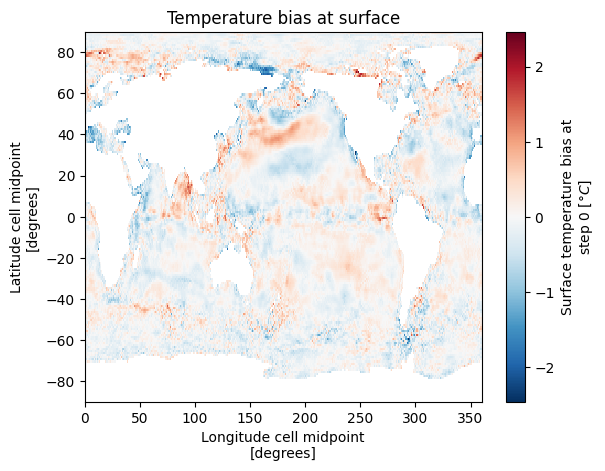

In [17]:
import matplotlib.pyplot as plt
surface_temp_bias = (ds_prediction - ds_groundtruth).thetao.isel(time=0, lev=0)
surface_temp_bias.rename(r"Surface temperature bias at step 0 [$\degree C$]").plot()
plt.title("Temperature bias at surface")
plt.show()